# Introduction
Inspired by predicting sales of things dependent of multivariate observations (eg day of week, holidays) and so on

## Prepare data
Before using deflate train and test data that has been downloaded before (kaggle competitions download -c rossmann-store-sales).

```
unzip -d ./input/rossmann-store-sales.zip ./input/
```

## Further literature
- [kaggle competition](https://www.kaggle.com/c/rossmann-store-sales)
- https://www.mdpi.com/2306-5729/4/1/15
- http://cs229.stanford.edu/proj2015/205_report.pdf

In [17]:
# ------- LIBARRY functions ---------
import numpy as np
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMAResults
# LIBRARY
from seaborn import histplot, relplot
from pandas import Series
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf

def plot_series_hist_acf_kpss(Yt: Series, lags=5, plot_lag_plot=False, hist_bins=15):
    # Yt
    f = relplot(data=Yt, kind='line', markers=True, height=20.0, aspect=1.5)
    plt.show()

    # ACF
    f = plot_acf(Yt, lags=lags)
    plt.show()

    ax = histplot(Yt, bins=hist_bins, kde=True)
    plt.show()

    # Compare median and mean
    print(Yt.describe())

    # https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html
    kpss_stat = kpss(Yt, regression='c', store=True)    # hypothesis: constant
    "KPSS={}".format(kpss_stat)# around a mean

    # Lag plot
    if (plot_lag_plot is True):
        ax = lag_plot(series=Yt, lag=lags)
        plt.show()

# Actual vs Fitted
def plot_actual_and_fitted_values(y_t: Series, model_fit: ARIMAResults):
    f, axes = plt.subplots(1, 1)
    f.set_size_inches(w=20, h=10)
    f = sns.lineplot(data=pd.DataFrame({'actual': y_t, 'fitted': model_fit.fittedvalues}), ax=axes)
    plt.show()

def errors(y_t, model_fit: ARIMAResults):
    fitted:Series = model_fit.fittedvalues[y_t.index]
    residuals:Series = model_fit.resid[y_t.index]
    return {
        'RMSE': np.sqrt(mean_squared_error(y_t, fitted)),
        'MAPE': mean_absolute_percentage_error(y_t, fitted),
        'MAX_ABS': residuals.abs().max(),
        'MIN_ABS': residuals.abs().min()}

# Preprocessing
Feature engineering, create categorial columns

In [18]:
import pandas as pd
from pandas import DataFrame

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

df_train: DataFrame = pd.read_csv('./input/train.csv', parse_dates=['Date'], dtype={'StateHoliday': str, 'Open': bool, 'Promo': bool, 'SchoolHoliday': bool})


In [19]:
from pandas.plotting import lag_plot
import seaborn as sns
import matplotlib.pyplot as plt

# Grouped by Store
df_train_stores = df_train.groupby(by=['Store'])
#df_train_stores.Date.max()
#df_train_stores.Date.min()
df_X = df_train_stores.get_group(2).set_index('Date')
sales_zero_idx = df_X[df_X['Sales'] == 0].index
df_X = df_X.drop(sales_zero_idx)
#df_X['2015-01-01':'2015-02-01'].tail(10)
#df_X.head(10)

def avg_sales_per_period(df: DataFrame) -> pd.Series:
    df_copy = df.copy()
    s_tmp: pd.Series = df['Sales'] / df['Open']
    df_copy['Sales_per_open_days_avg'] = s_tmp.astype('int')
    return df_copy


# resample/groupby WEEK
df_weekly_sum: DataFrame = df_X.resample("W").sum()
df_weekly_sum['Year'] = df_weekly_sum.index.year
df_weekly_sum['Week'] = df_weekly_sum.index.week
#df_weekly_sum['Week'] = df_weekly_sum.index.map(lambda week: week.strftime('%m-%d'))
df_weekly_sum = avg_sales_per_period(df_weekly_sum)
df_weekly_sum.head(5)

y_t = df_weekly_sum['Sales_per_open_days_avg']



/tmp/ipykernel_193984/4129727798.py:25: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_weekly_sum['Week'] = df_weekly_sum.index.week


,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Year,Week,Sales_per_open_days_avg
Date,,,,,,,,,,
2013-01-06,8,18,15407,2103,4,0,3,2013,1,3851
2013-01-13,12,21,32914,3746,6,5,0,2013,2,5485
2013-01-20,12,21,21081,2774,6,0,0,2013,3,3513
2013-01-27,12,21,29973,3415,6,5,0,2013,4,4995
2013-02-03,12,21,23297,3004,6,0,0,2013,5,3882


# Auto-regression | Analysis

Here we try to use auto-regressive analysis to see whether there is a auto-correlation between defined lags

## Seasonal model
A time series is periodic if it repeats itself at equally spaced intervals, say, every 12 months, every 1 week, every 4 months, and so on.
Let us check if our time series has some seasonality element to it.

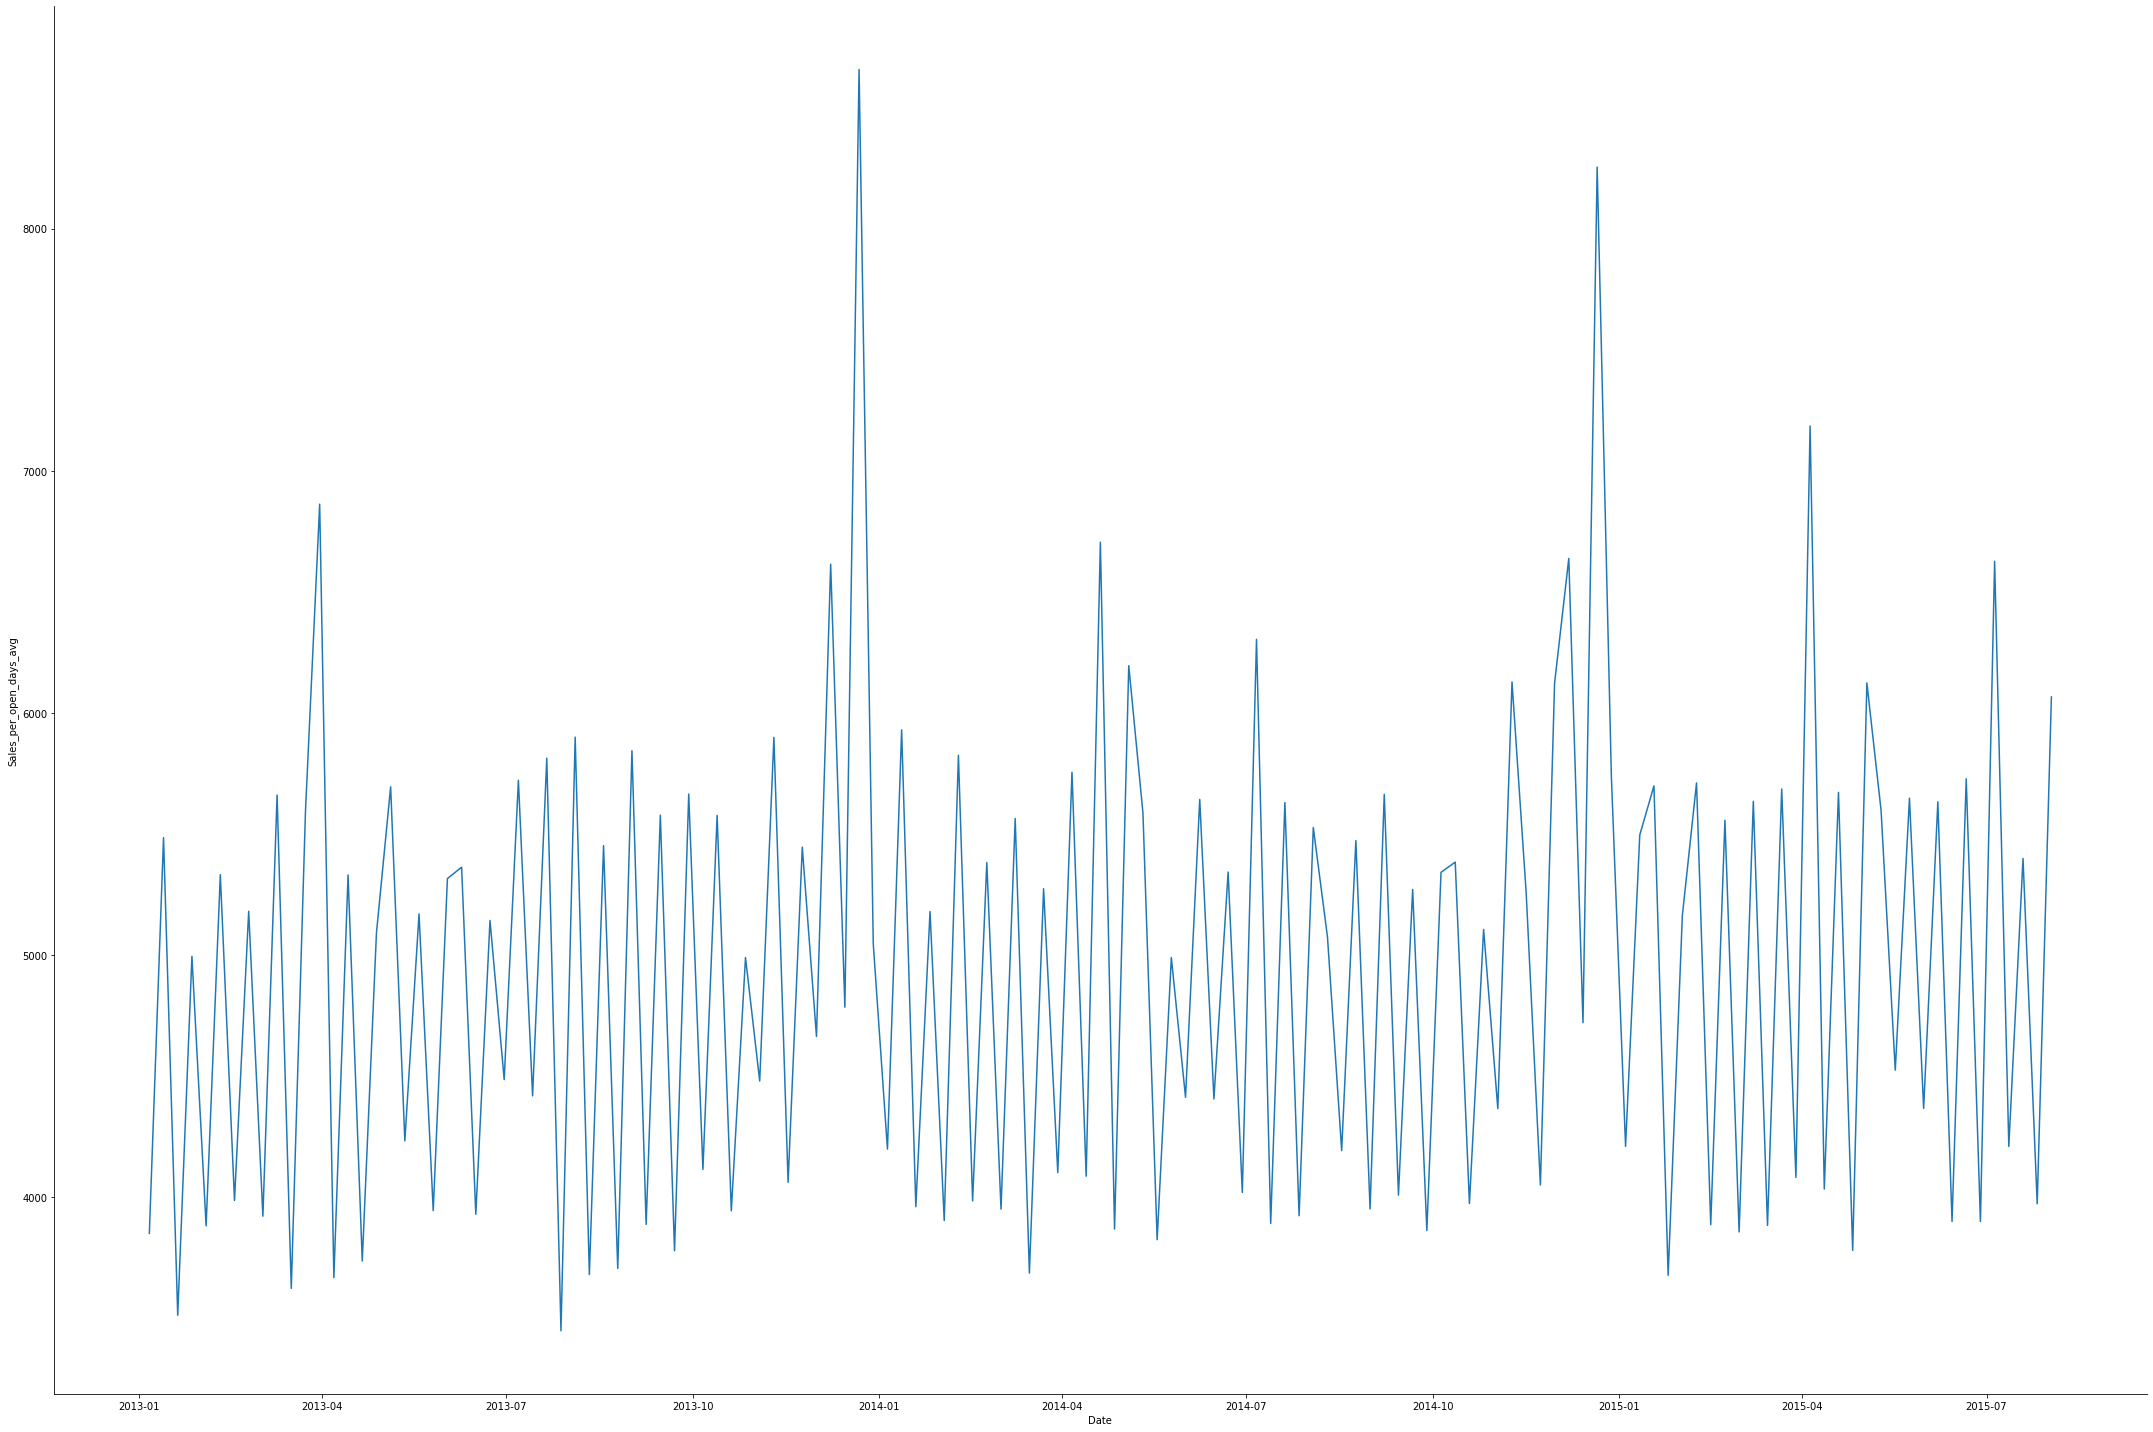

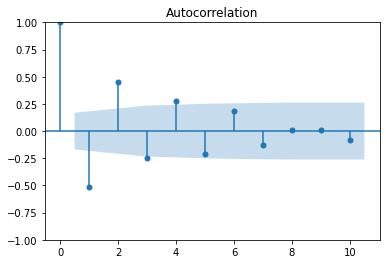

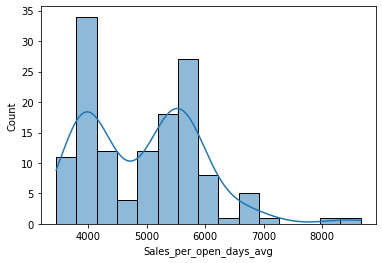

count     135.000000
mean     4953.525926
std       991.336071
min      3449.000000
25%      3979.500000
50%      5106.000000
75%      5639.000000
max      8657.000000
Name: Sales_per_open_days_avg, dtype: float64


/usr/local/src/git/github/bruennijs/kaggle_rossmann_sales_prediction/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


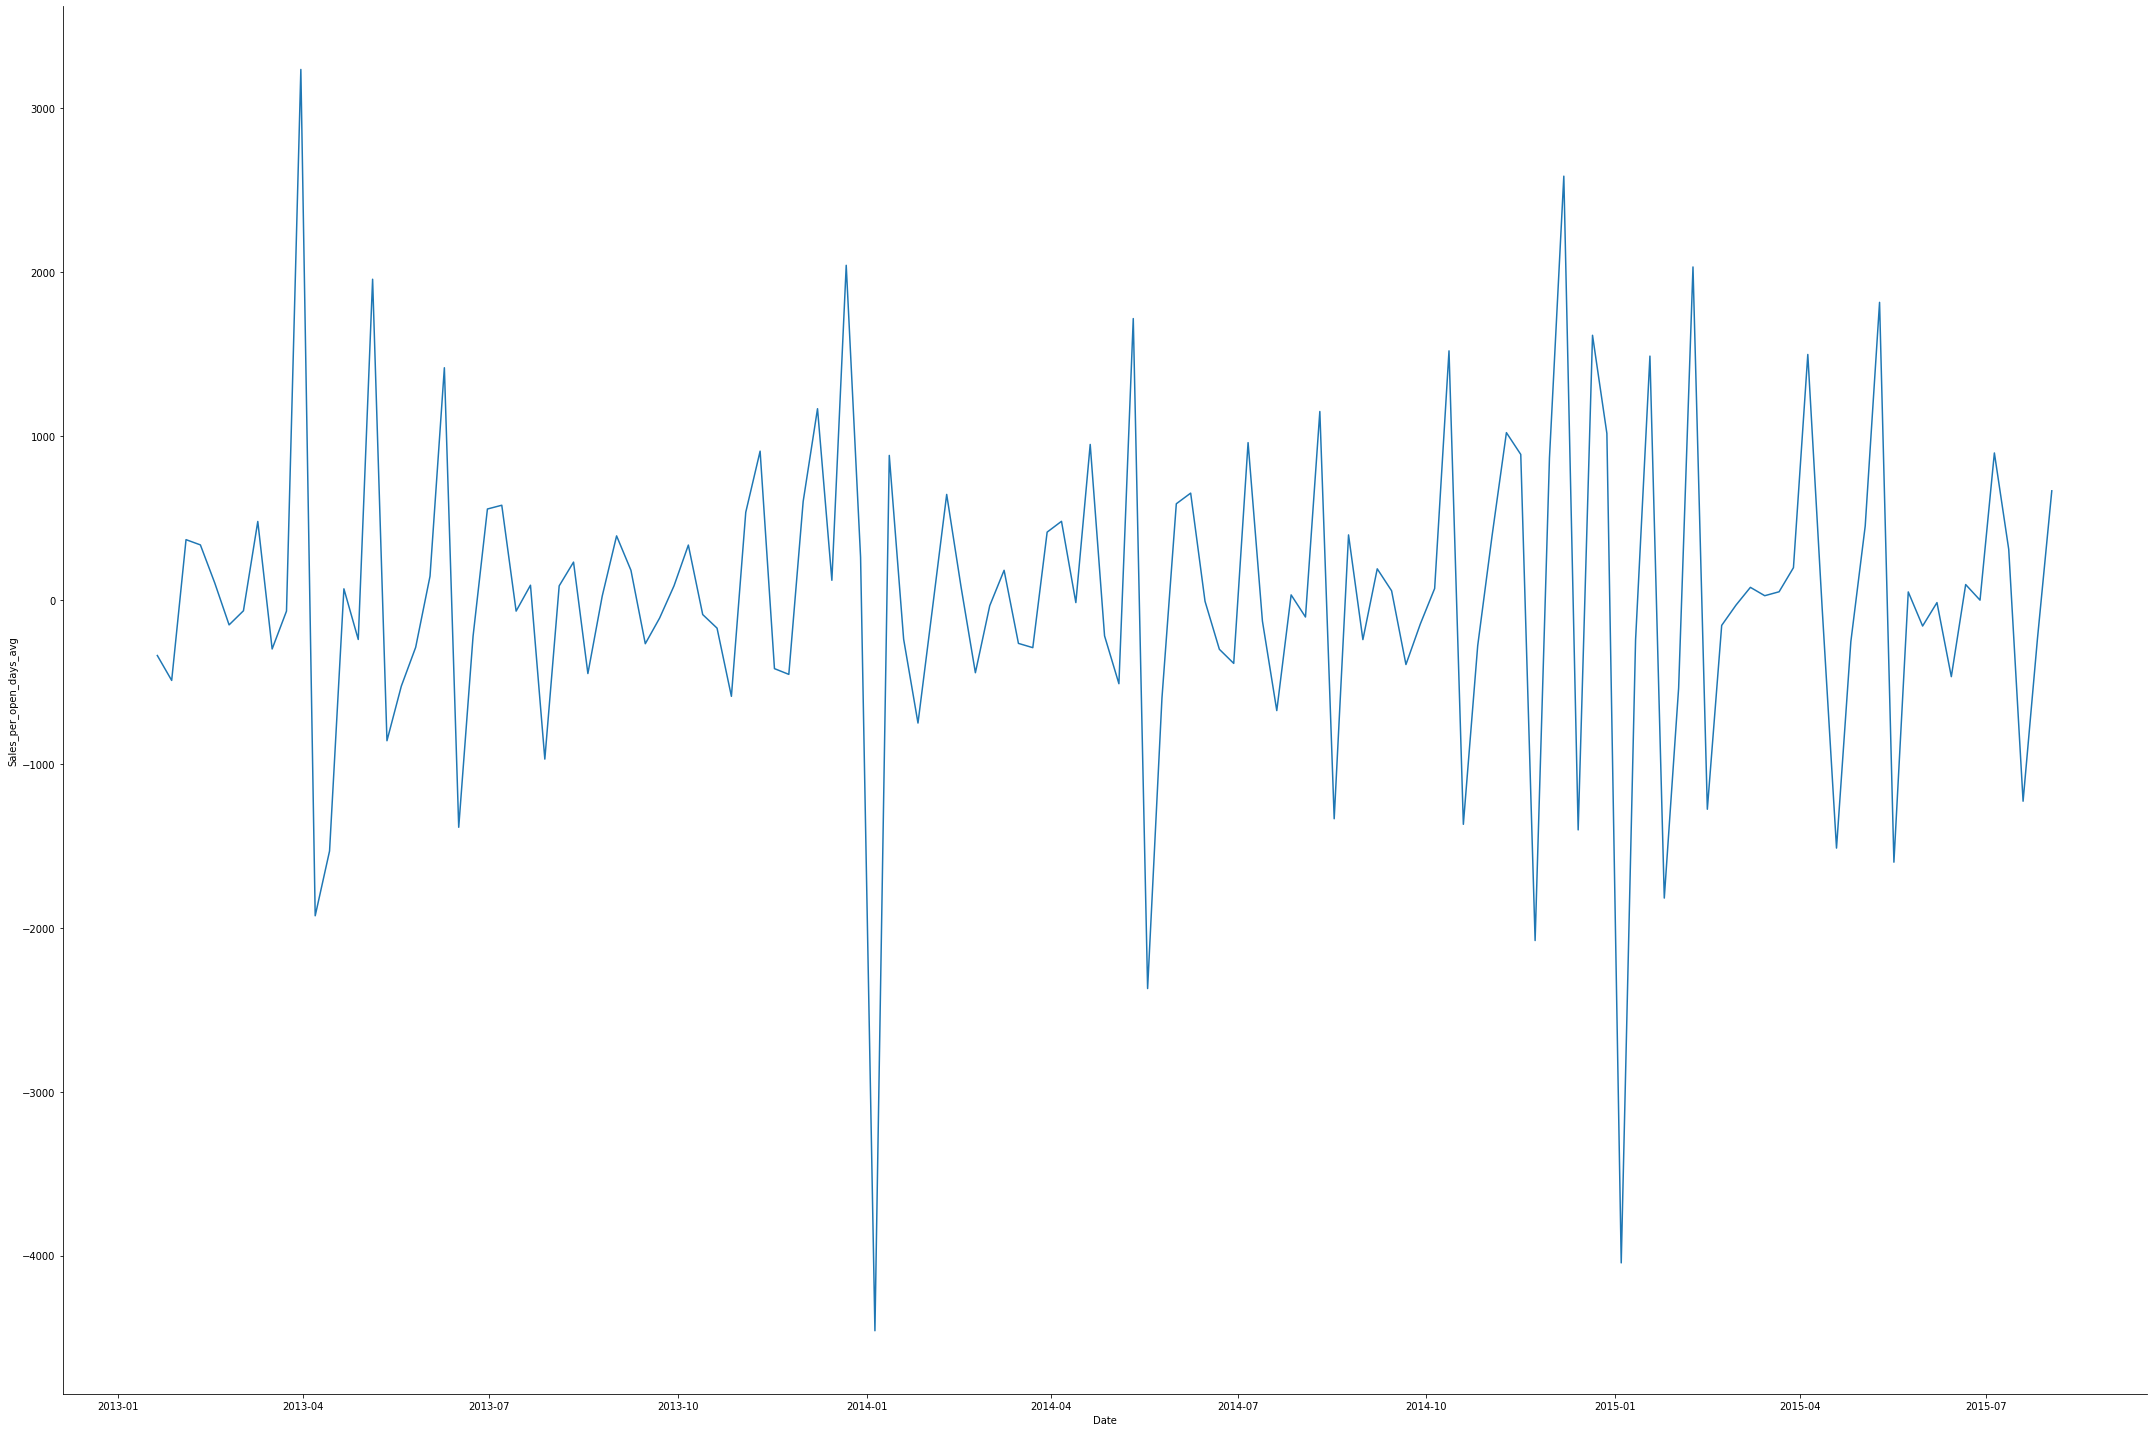

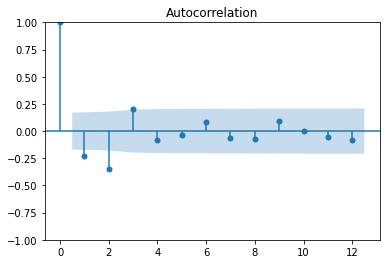

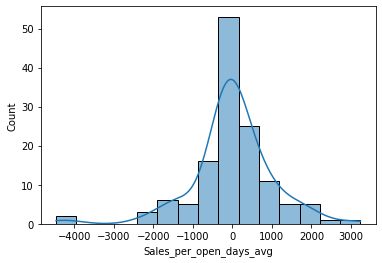

count     133.000000
mean        5.285714
std      1032.389392
min     -4458.000000
25%      -300.000000
50%        -7.000000
75%       452.000000
max      3238.000000
Name: Sales_per_open_days_avg, dtype: float64


/usr/local/src/git/github/bruennijs/kaggle_rossmann_sales_prediction/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


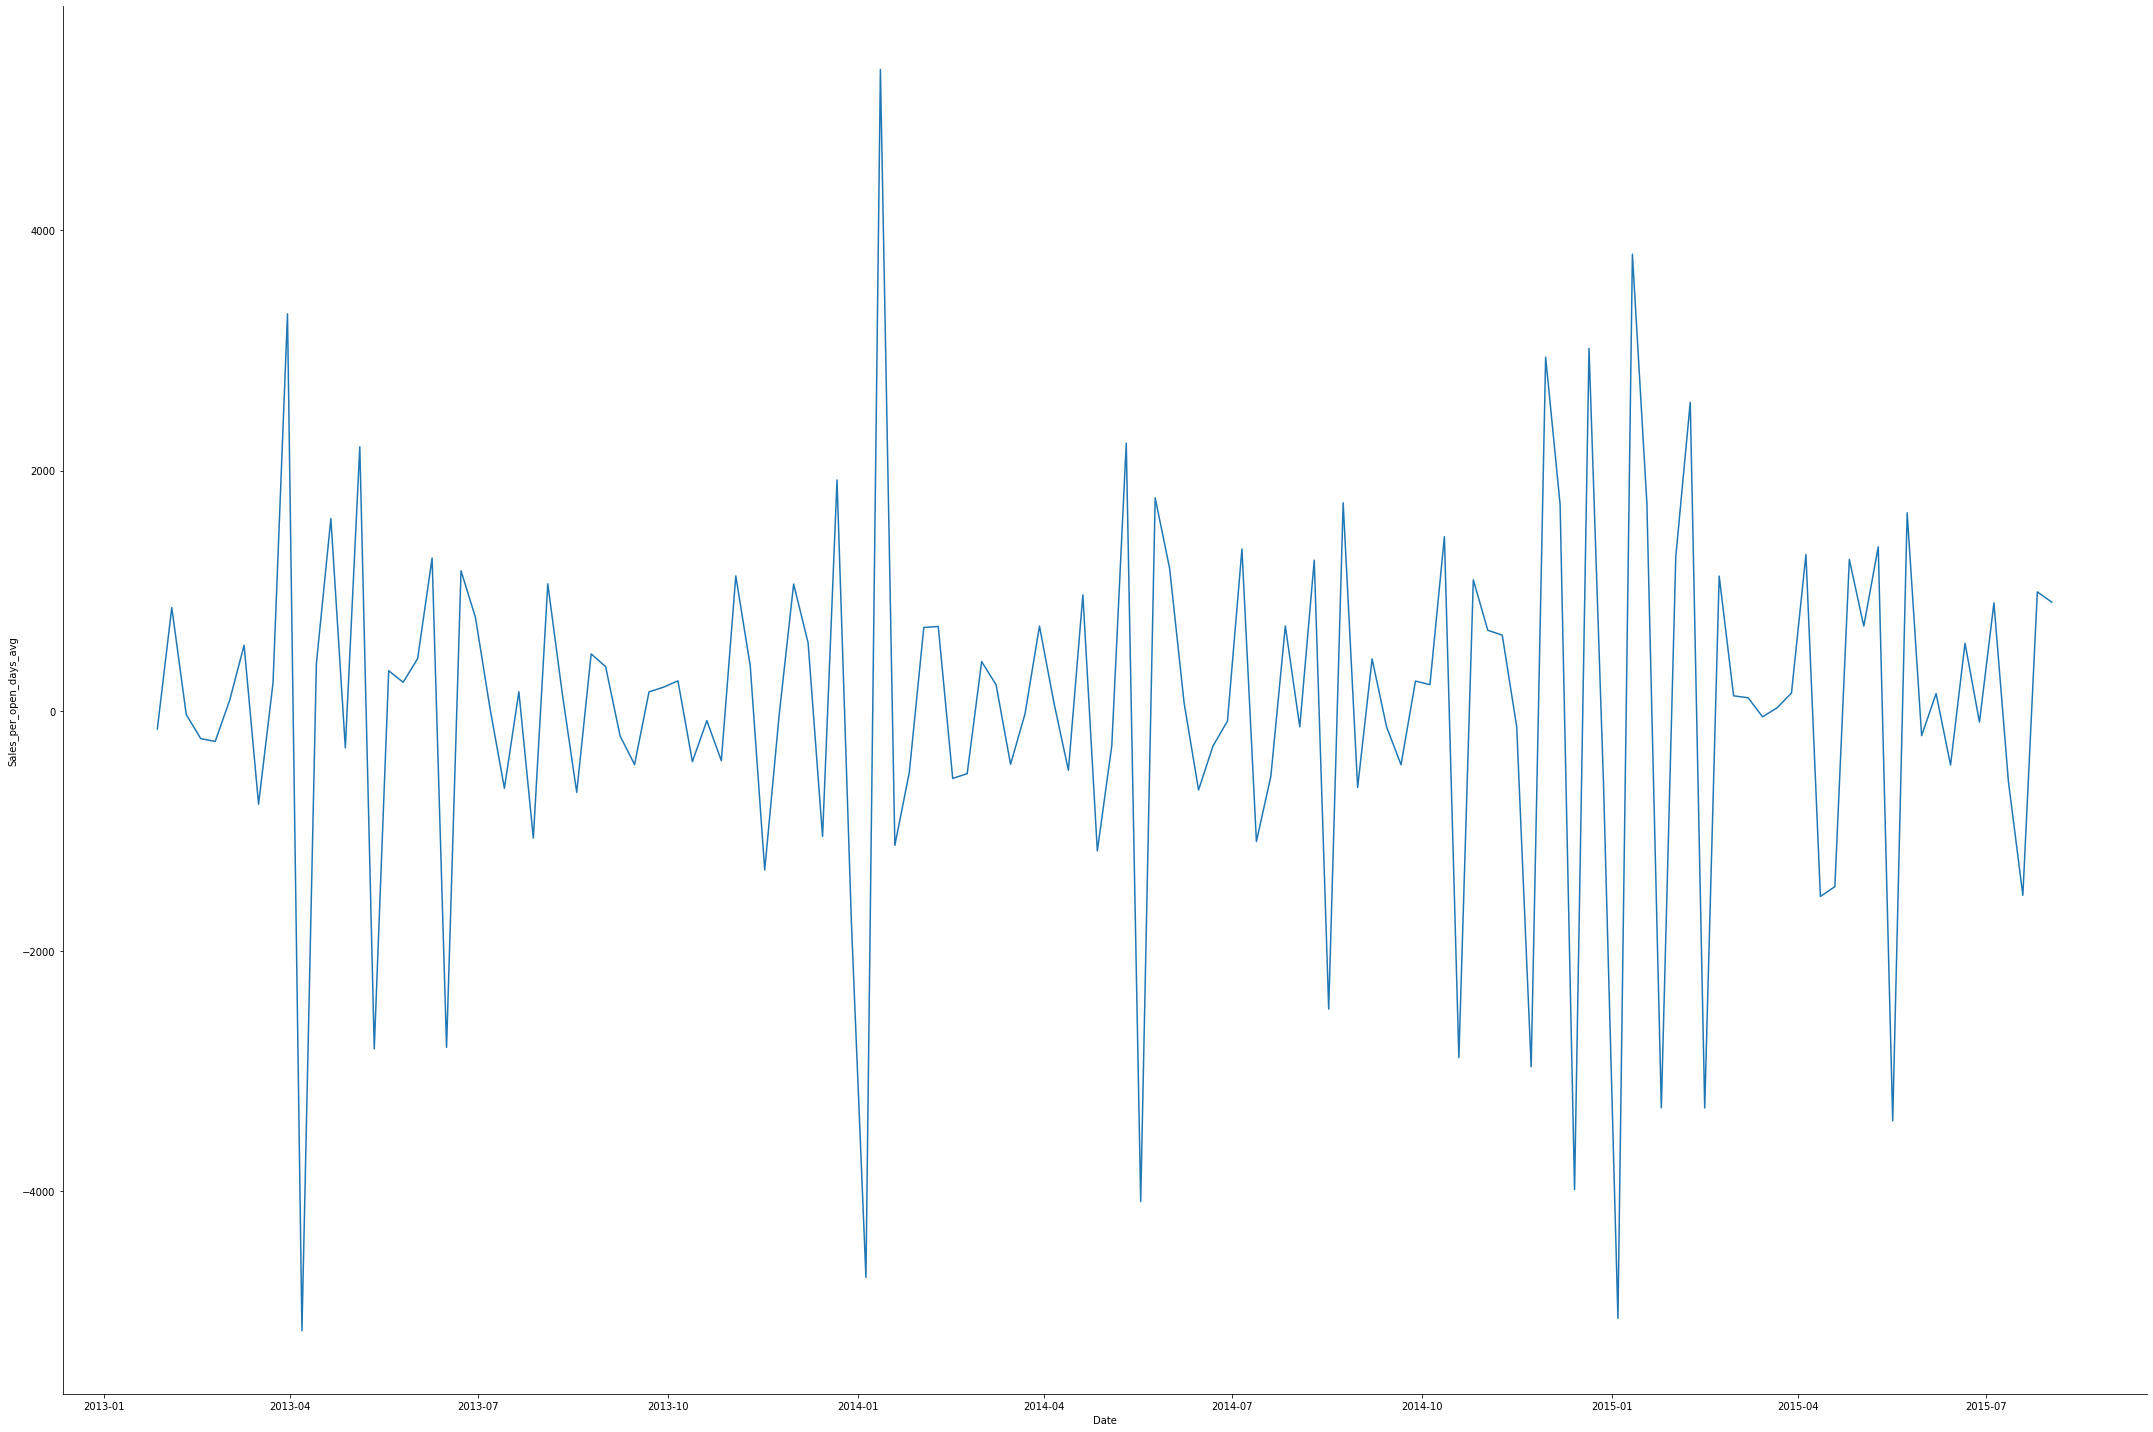

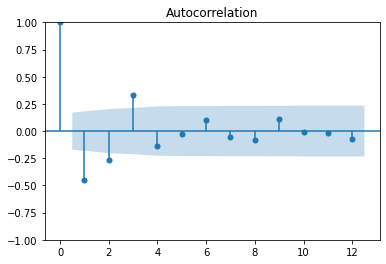

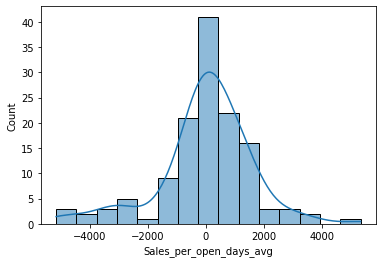

count     132.000000
mean        7.613636
std      1626.517610
min     -5164.000000
25%      -515.000000
50%       133.500000
75%       899.500000
max      5341.000000
Name: Sales_per_open_days_avg, dtype: float64


/usr/local/src/git/github/bruennijs/kaggle_rossmann_sales_prediction/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


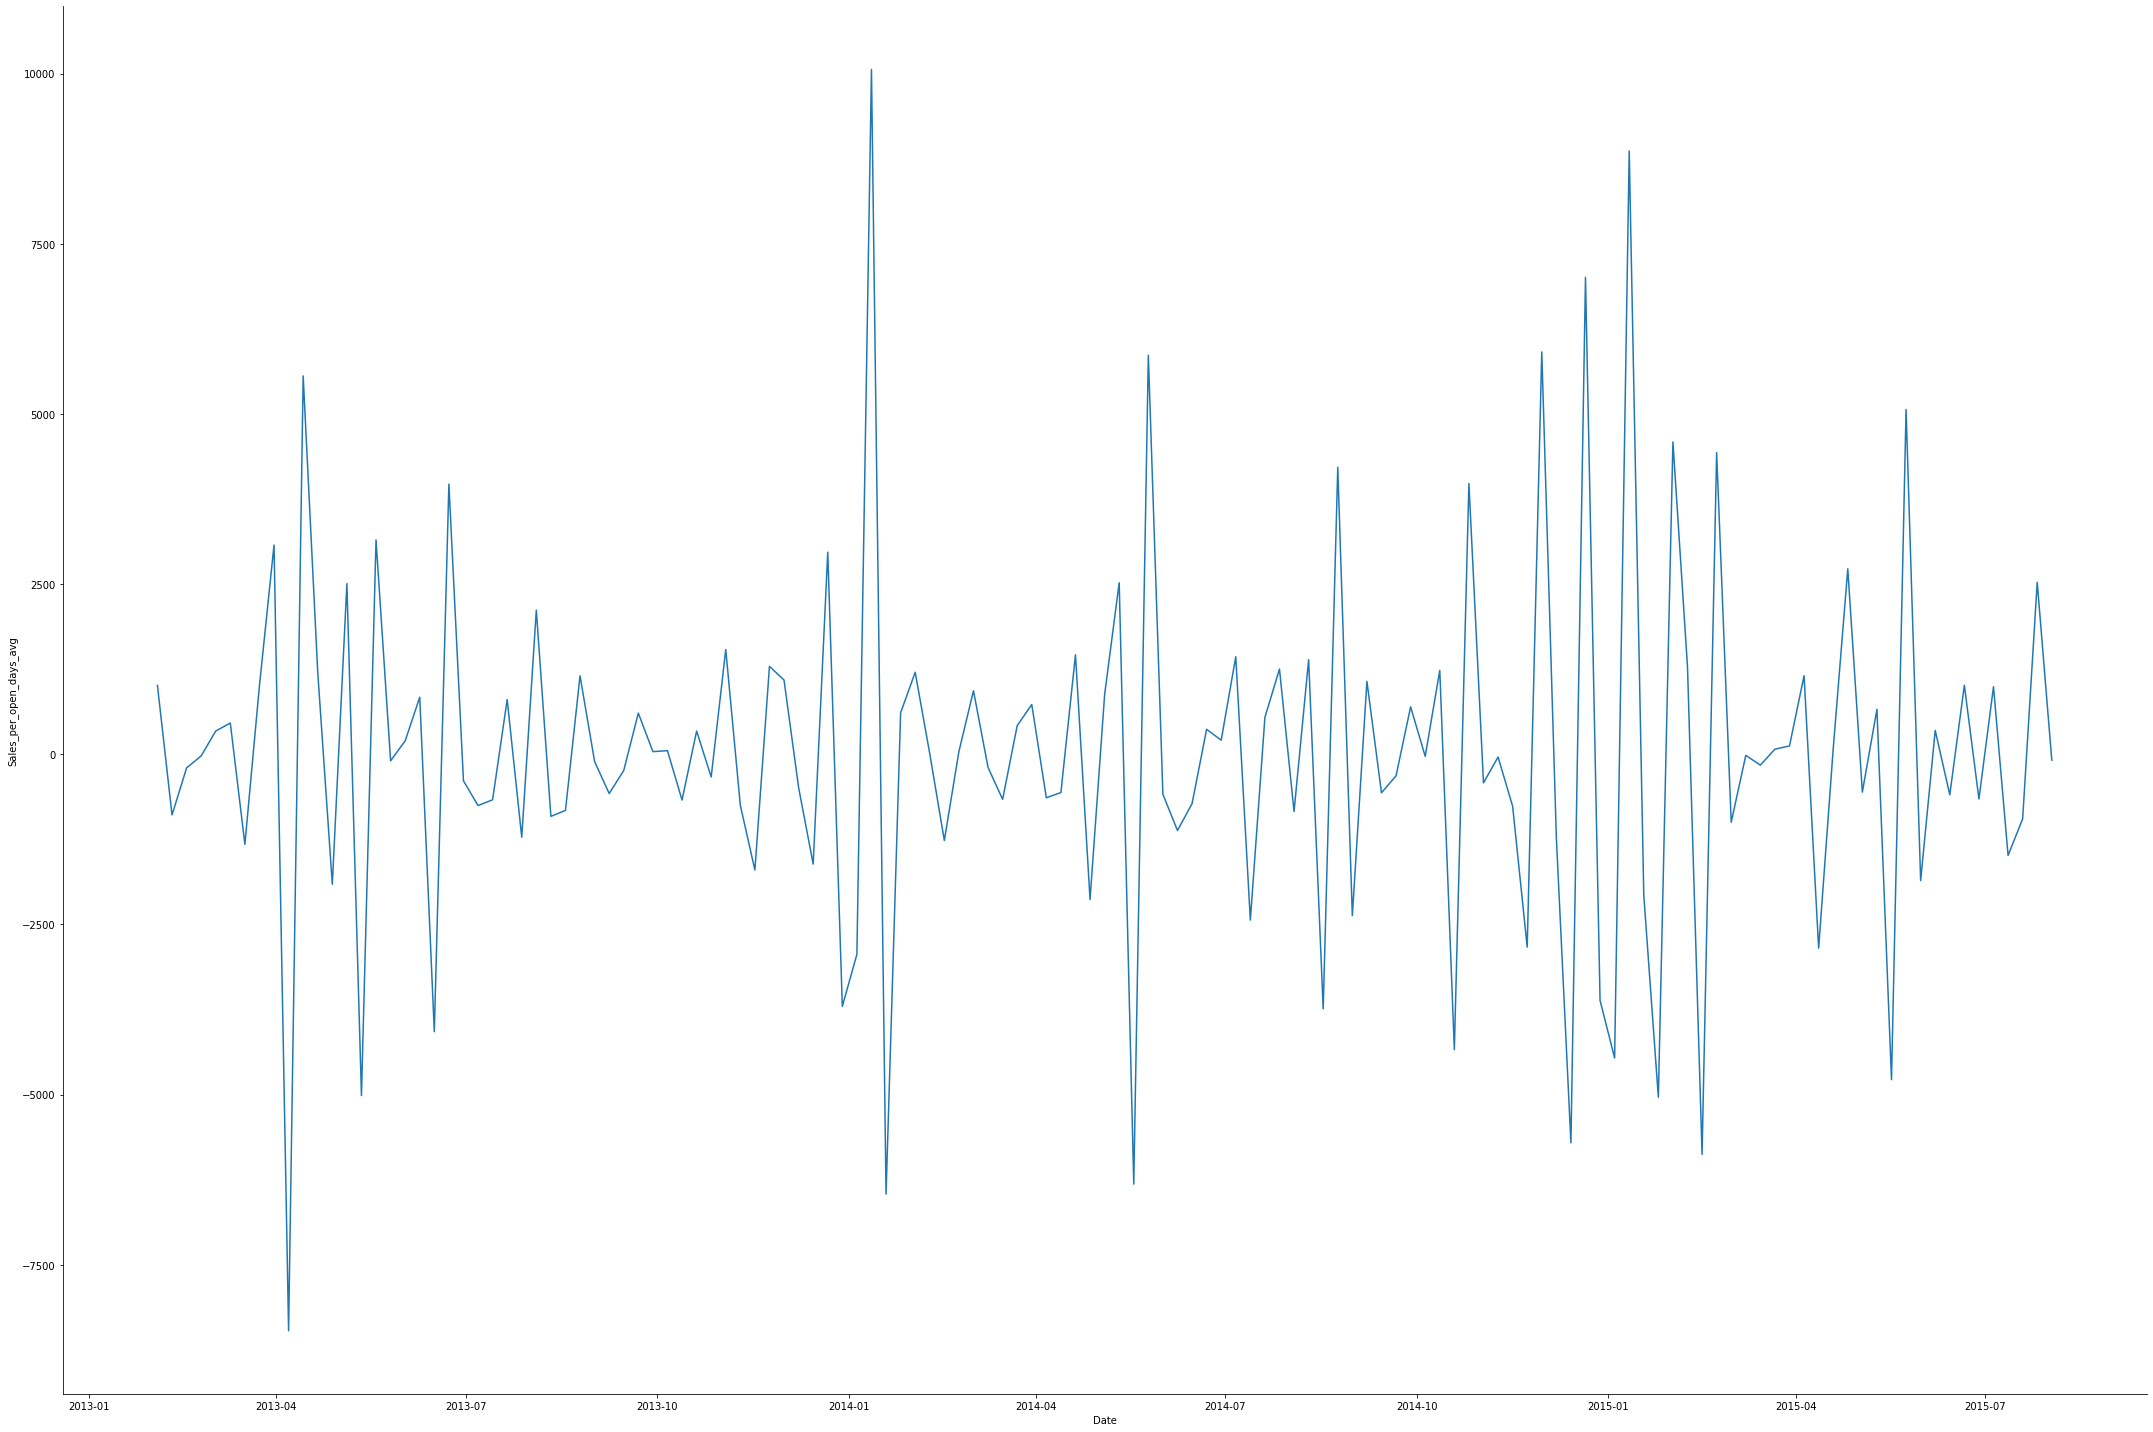

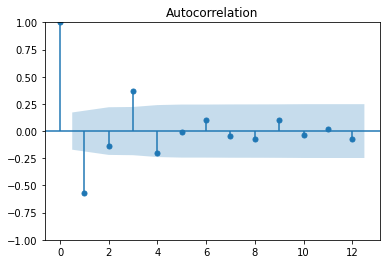

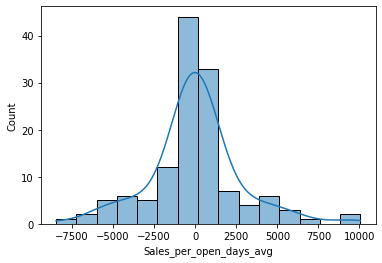

count      131.000000
mean         8.061069
std       2783.271815
min      -8469.000000
25%       -930.500000
50%        -30.000000
75%       1080.500000
max      10061.000000
Name: Sales_per_open_days_avg, dtype: float64


/usr/local/src/git/github/bruennijs/kaggle_rossmann_sales_prediction/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [44]:
from statsmodels.tsa.statespace.tools import diff

plot_series_hist_acf_kpss(y_t, lags=10)

y_t_diff = diff(series=y_t, k_diff=0, k_seasonal_diff=1, seasonal_periods=2)
plot_series_hist_acf_kpss(y_t_diff, lags=12)

y_t_diff = diff(series=y_t_diff, k_diff=1)
plot_series_hist_acf_kpss(y_t_diff, lags=12)


## Interpretation | Seasonal differencing
The seasonal differenced series seams to be almost stationary cause the mean is near zero and median almost equal.
So we assume to use a seasonal random walk model cause we need no further differencing cause no more lags (non-seasonal or seasonal) are auto correlated. Why, see [here](https://people.duke.edu/~rnau/411searw.htm)

# Forecast | Seasonal random walk with constant

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     Sales_per_open_days_avg   No. Observations:                  135
Model:                 SARIMAX(0, 1, 0, 2)   Log Likelihood               -1111.188
Date:                     Wed, 24 Nov 2021   AIC                           2226.376
Time:                             17:07:01   BIC                           2232.156
Sample:                         01-06-2013   HQIC                          2228.725
                              - 08-02-2015                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.2857     93.366      0.057      0.955    -177.708     188.279
sigma2      1.058e+06   7.85e+04     13.481      0.000    9.04e+05    1.21e+06
===================================================================================
Ljung-Box (L1) (Q):                   7.43   Jarque-Bera (JB):                99.89
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               2.15   Skew:                            -0.72
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

{'RMSE': 1028.5009061036692,
 'MAPE': 0.136210134664234,
 'MAX_ABS': 4463.285714285714,
 'MIN_ABS': 5.285714285713766}

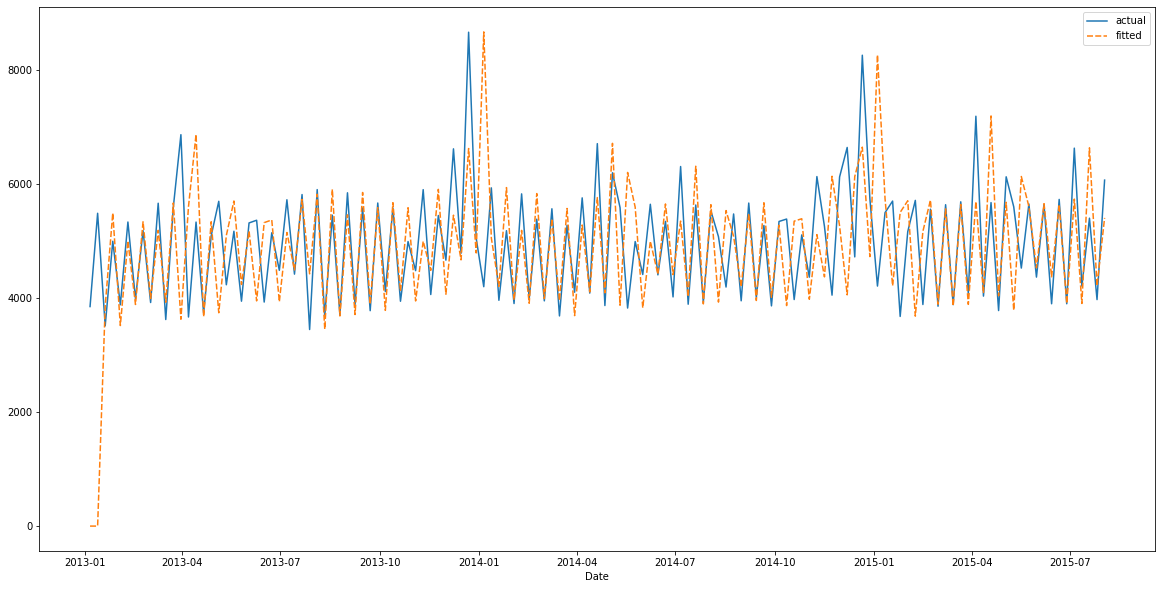

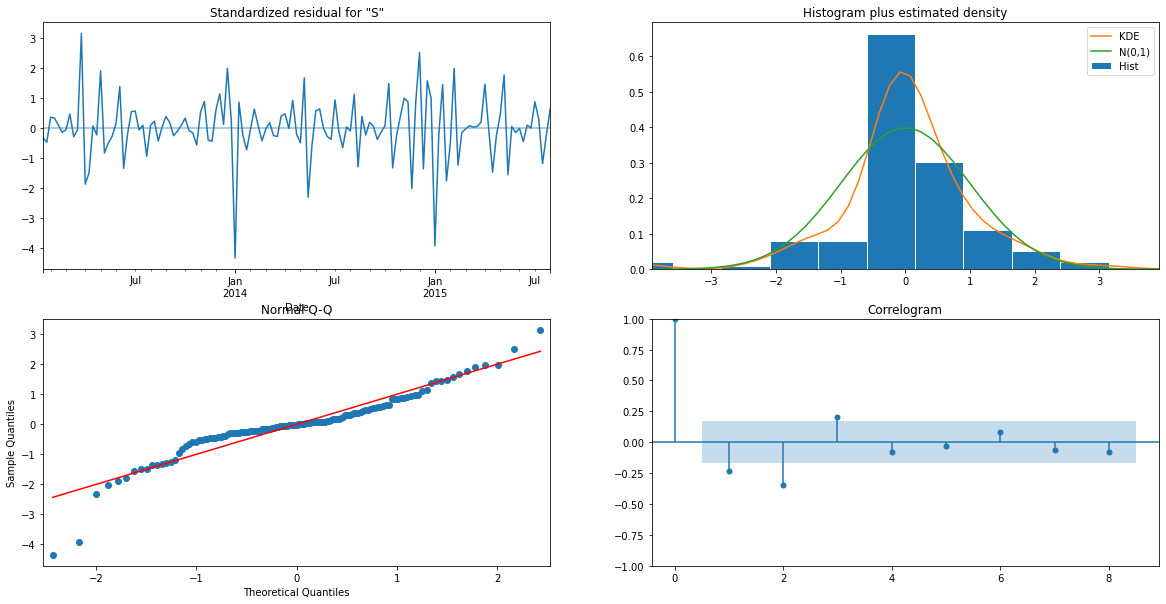

In [80]:
from matplotlib.figure import Figure
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMAResults

model: SARIMAX = SARIMAX(y_t, order=(0, 0, 0), seasonal_order=(0, 1, 0, 2), trend='c')
model_fit: ARIMAResults = model.fit(disp=False)
model_fit.summary()

errors_dict: dict[str, float] = errors(y_t.iloc[2:], model_fit)
errors_dict

# Plot actual vs fitted values
plot_actual_and_fitted_values(y_t, model_fit)

# Residuals diagnostics
figure: Figure = model_fit.plot_diagnostics(lags=8, figsize=(20, 10))
plt.show()

# Forecast | Seasonal random trend (ARIMA(0, 0, 2) x SARIMA(0,1,0, 2) period 2 with constant

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:            Sales_per_open_days_avg   No. Observations:                  135
Model:             SARIMAX(0, 0, 2)x(0, 1, [], 2)   Log Likelihood               -1091.299
Date:                            Wed, 24 Nov 2021   AIC                           2190.599
Time:                                    17:16:29   BIC                           2202.160
Sample:                                01-06-2013   HQIC                          2195.297
                                     - 08-02-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      7.4321      3.260      2.280      0.023       1.042      13.822
ma.L1         -0.4315      0.113     -3.804      0.000      -0.654      -0.209
ma.L2         -0.5685      0.076     -7.507      0.000      -0.717      -0.420
sigma2      7.109e+05   1.65e-07   4.31e+12      0.000    7.11e+05    7.11e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                55.22
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.76   Skew:                             1.09
Prob(H) (two-sided):                  0.06   Kurtosis:                         5.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.8e+30. Standard errors may be unstable.
"""

{'RMSE': 884.6721819113161,
 'MAPE': 0.1256985524479499,
 'MAX_ABS': 3486.8441735126084,
 'MIN_ABS': 2.389144628135}

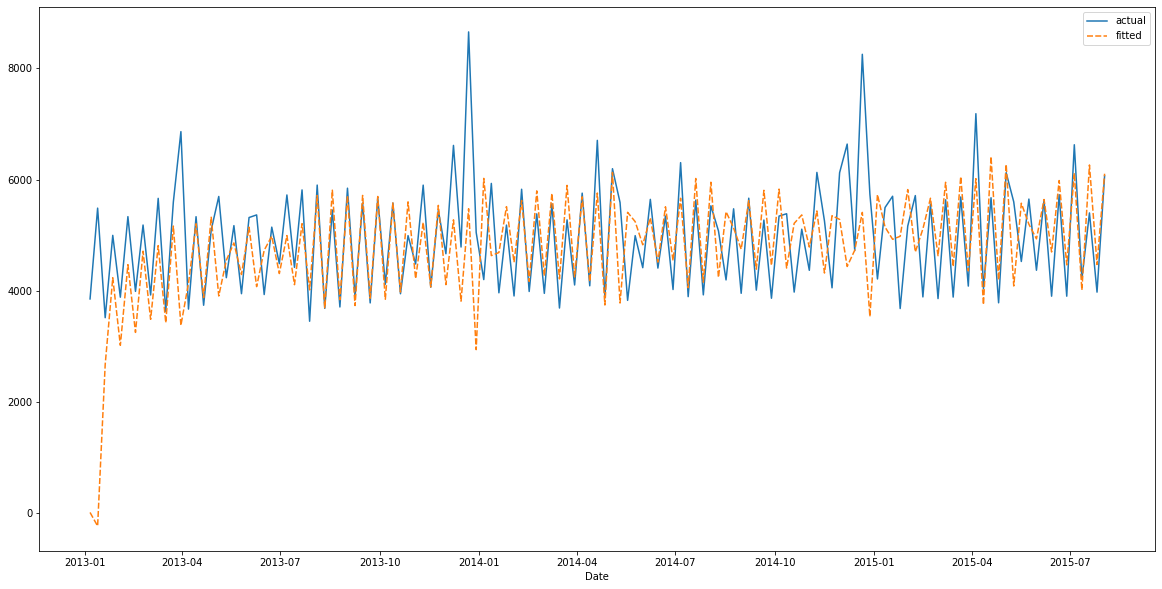

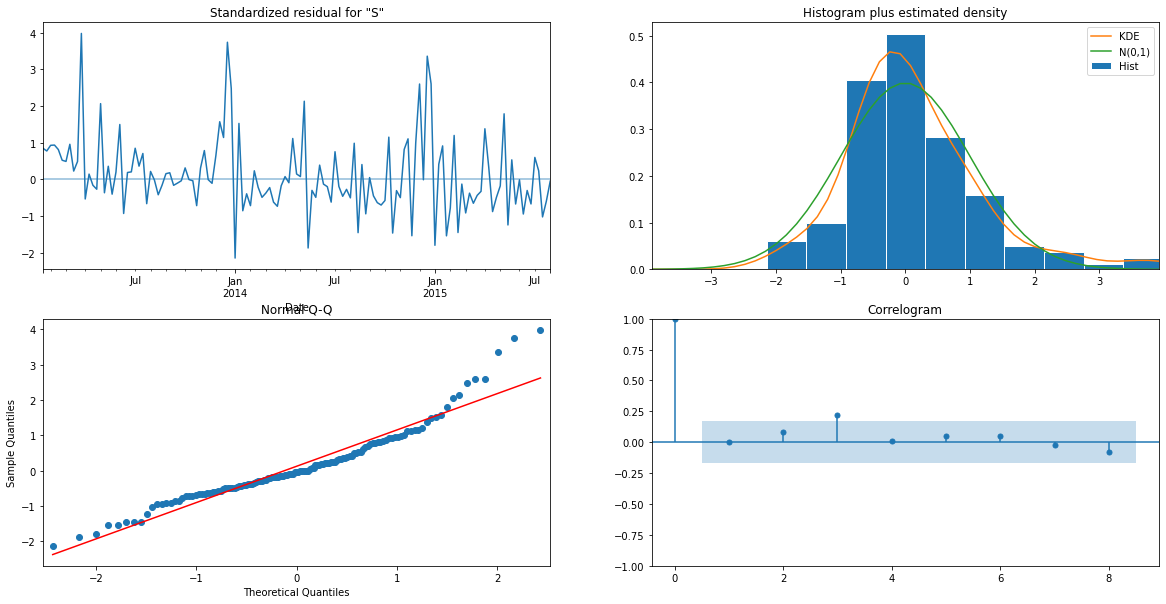

In [111]:
from matplotlib.figure import Figure
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMAResults

model: SARIMAX = SARIMAX(y_t, order=(0, 0, 2), seasonal_order=(0, 1, 0, 2), trend='c')
model_fit: ARIMAResults = model.fit(disp=False)
model_fit.summary()

errors_dict: dict[str, float] = errors(y_t.iloc[2:], model_fit)
errors_dict

# Plot actual vs fitted values
plot_actual_and_fitted_values(y_t, model_fit)

# Residuals diagnostics
figure: Figure = model_fit.plot_diagnostics(lags=8, figsize=(20, 10))
plt.show()